In [296]:
import pandas as pd
import geopandas as gpd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import sklearn
import math
import re

sns.set(style="ticks", color_codes=True)
%matplotlib inline 

In [442]:
# read in data
def get_data(filename, headers = False, set_ind = False):
    if headers and isinstance(set_ind, int):
        data_df = pd.read_csv(filename, header = 0, index_col = set_ind)
    elif headers and not set_ind:
        data_df = pd.read_csv(filename, header = 0)
    else:
        data_df = pd.read_csv(filename)
    return data_df

In [443]:
source = "/Users/lorenh/Documents/Classes/Spring Quarter 2018/Machine Learning for Public Policy/Homework Assignments/HW2/credit-data.csv"

In [444]:
credit_df = get_data(filename = source, headers = True, set_ind = 0)

1


In [445]:
credit_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [449]:
# explore statistics of all columns
credit_df.describe().round()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.0,41016.0,41016.0,41016.0,41016.0,41016.0,33042.0,41016.0,41016.0,41016.0,41016.0,39979.0
mean,0.0,6.0,52.0,60624.0,1.0,331.0,6579.0,8.0,0.0,1.0,0.0,1.0
std,0.0,222.0,15.0,12.0,5.0,1296.0,13447.0,5.0,5.0,1.0,5.0,1.0
min,0.0,0.0,21.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,41.0,60618.0,0.0,0.0,3333.0,5.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,51.0,60625.0,0.0,0.0,5250.0,8.0,0.0,1.0,0.0,0.0
75%,0.0,1.0,62.0,60629.0,0.0,1.0,8056.0,11.0,0.0,2.0,0.0,1.0
max,1.0,22000.0,109.0,60644.0,98.0,106885.0,1794060.0,56.0,98.0,32.0,98.0,13.0


In [6]:
# Null frequency tabulation for each column
# Attribution: https://github.com/yhat/DataGotham2013/blob/master/analysis/main.py
def print_null_freq(df):
    """
    for a given DataFrame, calculates how many values for each variable is null
    and prints the resulting table to stdout
    """
    df_lng = pd.melt(df)
    null_variables = df_lng.value.isnull()
    print(pd.crosstab(df_lng.variable, null_variables))


In [7]:
copy_df = credit_df

In [8]:
print_null_freq(copy_df)

value                                 False  True 
variable                                          
DebtRatio                             41016      0
MonthlyIncome                         33042   7974
NumberOfDependents                    39979   1037
NumberOfOpenCreditLinesAndLoans       41016      0
NumberOfTime30-59DaysPastDueNotWorse  41016      0
NumberOfTime60-89DaysPastDueNotWorse  41016      0
NumberOfTimes90DaysLate               41016      0
NumberRealEstateLoansOrLines          41016      0
RevolvingUtilizationOfUnsecuredLines  41016      0
SeriousDlqin2yrs                      41016      0
age                                   41016      0
zipcode                               41016      0


In [18]:
def basic_fill_vals(df, col_name, method = None):
    if method == "zeros":
        df[col_name] = df[col_name].fillna(0)
    elif method == "mean":
        replacement_val = df[col_name].median()
        df[col_name] = df[col_name].fillna(replacement_val)
    elif method == "mean":
        replacement_val = df[col_name].mean()
        df[col_name] = df[col_name].fillna(replacement_val)

In [ ]:
# fill null values  with basic 
basic_fill_vals(copy_df, "NumberOfDependents", method = "zeros")

In [16]:
basic_fill_vals(copy_df, "MonthlyIncome", method = "mean")

In [17]:
print_null_freq(copy_df)

value                                 False
variable                                   
DebtRatio                             41016
MonthlyIncome                         41016
NumberOfDependents                    41016
NumberOfOpenCreditLinesAndLoans       41016
NumberOfTime30-59DaysPastDueNotWorse  41016
NumberOfTime60-89DaysPastDueNotWorse  41016
NumberOfTimes90DaysLate               41016
NumberRealEstateLoansOrLines          41016
RevolvingUtilizationOfUnsecuredLines  41016
SeriousDlqin2yrs                      41016
age                                   41016
zipcode                               41016


### Feature Distribution

In [453]:
# view distributions of features
def view_dist(df, categoricals_list):
    print("Feature Frequencies")
    df.drop(categoricals_list, axis = 1).hist(bins = 50, figsize=(20,15), color = 'blue')
    plt.annotate('Source: City of Chicago Open Data Portal', xy=(0.7,-0.2), xycoords="axes fraction")
    plt.show()

Feature Frequencies


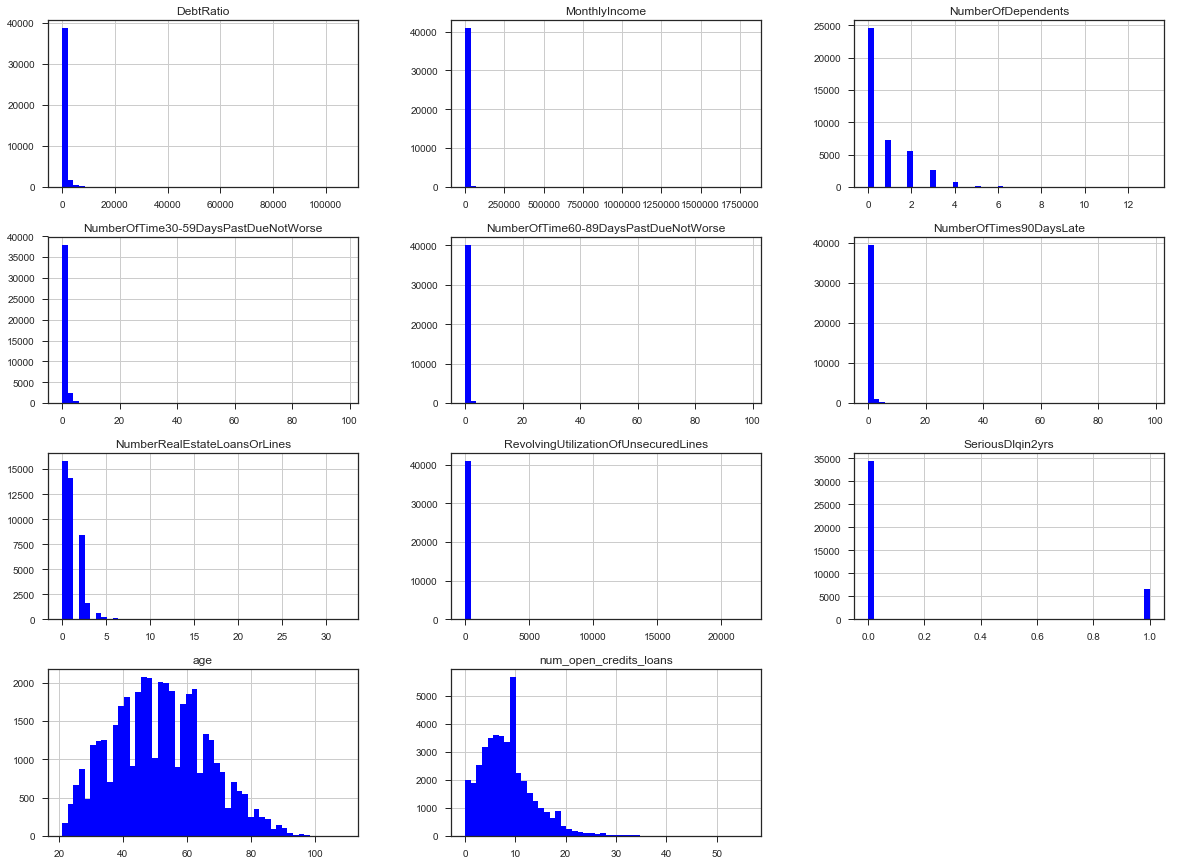

In [454]:
view_dist(copy_df, ["zipcode"])

In [81]:
# develop quick check of column position via dictionary
def create_col_ref(df):
    col_list = df.columns
    col_dict = {}
    for list_position, col_name in enumerate(col_list):
        col_dict[col_name] = list_position
    return col_dict

In [82]:
col_ref = create_col_ref(credit_df)
print(col_ref)

{'SeriousDlqin2yrs': 0, 'RevolvingUtilizationOfUnsecuredLines': 1, 'age': 2, 'zipcode': 3, 'NumberOfTime30-59DaysPastDueNotWorse': 4, 'DebtRatio': 5, 'MonthlyIncome': 6, 'NumberOfOpenCreditLinesAndLoans': 7, 'NumberOfTimes90DaysLate': 8, 'NumberRealEstateLoansOrLines': 9, 'NumberOfTime60-89DaysPastDueNotWorse': 10, 'NumberOfDependents': 11}


### Feature Correlation 

#### Pearson Correlation

In [98]:
# Check linear correlation between non-categorical variables
# Colormap Attribution: https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials

def check_corr(df, categorical_list)
    df.drop(categorical_list, axis = 1).corr(method="pearson").style.format("{:.2}").background_gradient(cmap=plt.get_cmap("coolwarm"), axis = 1)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.0,-0.0046,-0.17,0.15,-0.014,-0.033,-0.04,0.14,-0.011,0.12,0.066
RevolvingUtilizationOfUnsecuredLines,-0.0046,1.0,-0.008,-0.002,0.022,0.0058,-0.015,-0.0017,0.0048,-0.0014,0.0053
age,-0.17,-0.008,1.0,-0.069,0.039,0.048,0.16,-0.069,0.049,-0.064,-0.21
NumberOfTime30-59DaysPastDueNotWorse,0.15,-0.002,-0.069,1.0,-0.012,-0.015,-0.071,0.98,-0.038,0.99,-0.0078
DebtRatio,-0.014,0.022,0.039,-0.012,1.0,-0.023,0.083,-0.015,0.18,-0.013,-0.071
MonthlyIncome,-0.033,0.0058,0.048,-0.015,-0.023,1.0,0.11,-0.018,0.13,-0.015,0.061
NumberOfOpenCreditLinesAndLoans,-0.04,-0.015,0.16,-0.071,0.083,0.11,1.0,-0.098,0.44,-0.087,0.06
NumberOfTimes90DaysLate,0.14,-0.0017,-0.069,0.98,-0.015,-0.018,-0.098,1.0,-0.055,0.99,-0.016
NumberRealEstateLoansOrLines,-0.011,0.0048,0.049,-0.038,0.18,0.13,0.44,-0.055,1.0,-0.048,0.11
NumberOfTime60-89DaysPastDueNotWorse,0.12,-0.0014,-0.064,0.99,-0.013,-0.015,-0.087,0.99,-0.048,1.0,-0.016


#### Discretization of Non-categorical Variables

In [392]:
def discretize_cols(df, cols_to_bin, num_bins):
    for col in cols_to_bin:
        bin_col = col + "_bin"
        if col == "age":
            num_bins = math.ceil((df[col].max() - df[col].min()) / 10)
            df[bin_col] = pd.cut(df[col], bins = num_bins, right = False, precision=0)
        else:
            try:
                df[bin_col] = pd.qcut(df[col], q = 7, precision=0)
            except:
                df[bin_col] = pd.qcut(df[col], q = 10, precision=0, duplicates = 'drop')

In [393]:
discretize_cols(df = copy_df, cols_to_bin = ['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 
                                                      'age','NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
                                                       'MonthlyIncome', 'num_open_credits_loans',
                                                       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
                                                       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents'], 
                num_bins = 3)

copy_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,num_open_credits_loans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,RevolvingUtilizationOfUnsecuredLines_bin,NumberOfTime30-59DaysPastDueNotWorse_bin,DebtRatio_bin,MonthlyIncome_bin,NumberOfOpenCreditLinesAndLoans_bin,NumberOfTimes90DaysLate_bin,NumberRealEstateLoansOrLines_bin,NumberOfTime60-89DaysPastDueNotWorse_bin,NumberOfDependents_bin,num_open_credits_loans_bin
PersonID,,,,,,,,,,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,...,"(0.9, 22000.0]","(-1.0, 1.0]","(332.7, 106885.0]","(-1.0, 2267.0]","[0.0, 18.667)","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 3.0]"
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,...,"(0.3, 0.6]","(-1.0, 1.0]","(0.4, 0.7]","(10583.0, 1794060.0]","[0.0, 18.667)","(-1.0, 98.0]","(1.0, 2.0]","(-1.0, 98.0]","(-1.0, 1.0]","(5.0, 7.0]"
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,...,"(0.01, 0.05]","(-1.0, 1.0]","(-0.1, 0.08]","(3330.0, 4230.0]","[0.0, 18.667)","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(-1.0, 1.0]","(3.0, 5.0]"
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,...,"(0.6, 0.9]","(1.0, 98.0]","(0.7, 332.7]","(8094.0, 10583.0]","[0.0, 18.667)","(-1.0, 98.0]","(2.0, 32.0]","(-1.0, 98.0]","(-1.0, 1.0]","(11.0, 14.0]"
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,...,"(0.01, 0.05]","(-1.0, 1.0]","(-0.1, 0.08]","(8094.0, 10583.0]","[0.0, 18.667)","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(1.0, 2.0]","(3.0, 5.0]"


In [394]:
# observe distributions and correlations of features 
def plot_corr(df, categoricals_list, color_category):
    corr = sns.pairplot(df.drop(categoricals_list, axis = 1), hue = color_category, palette = "Set2")

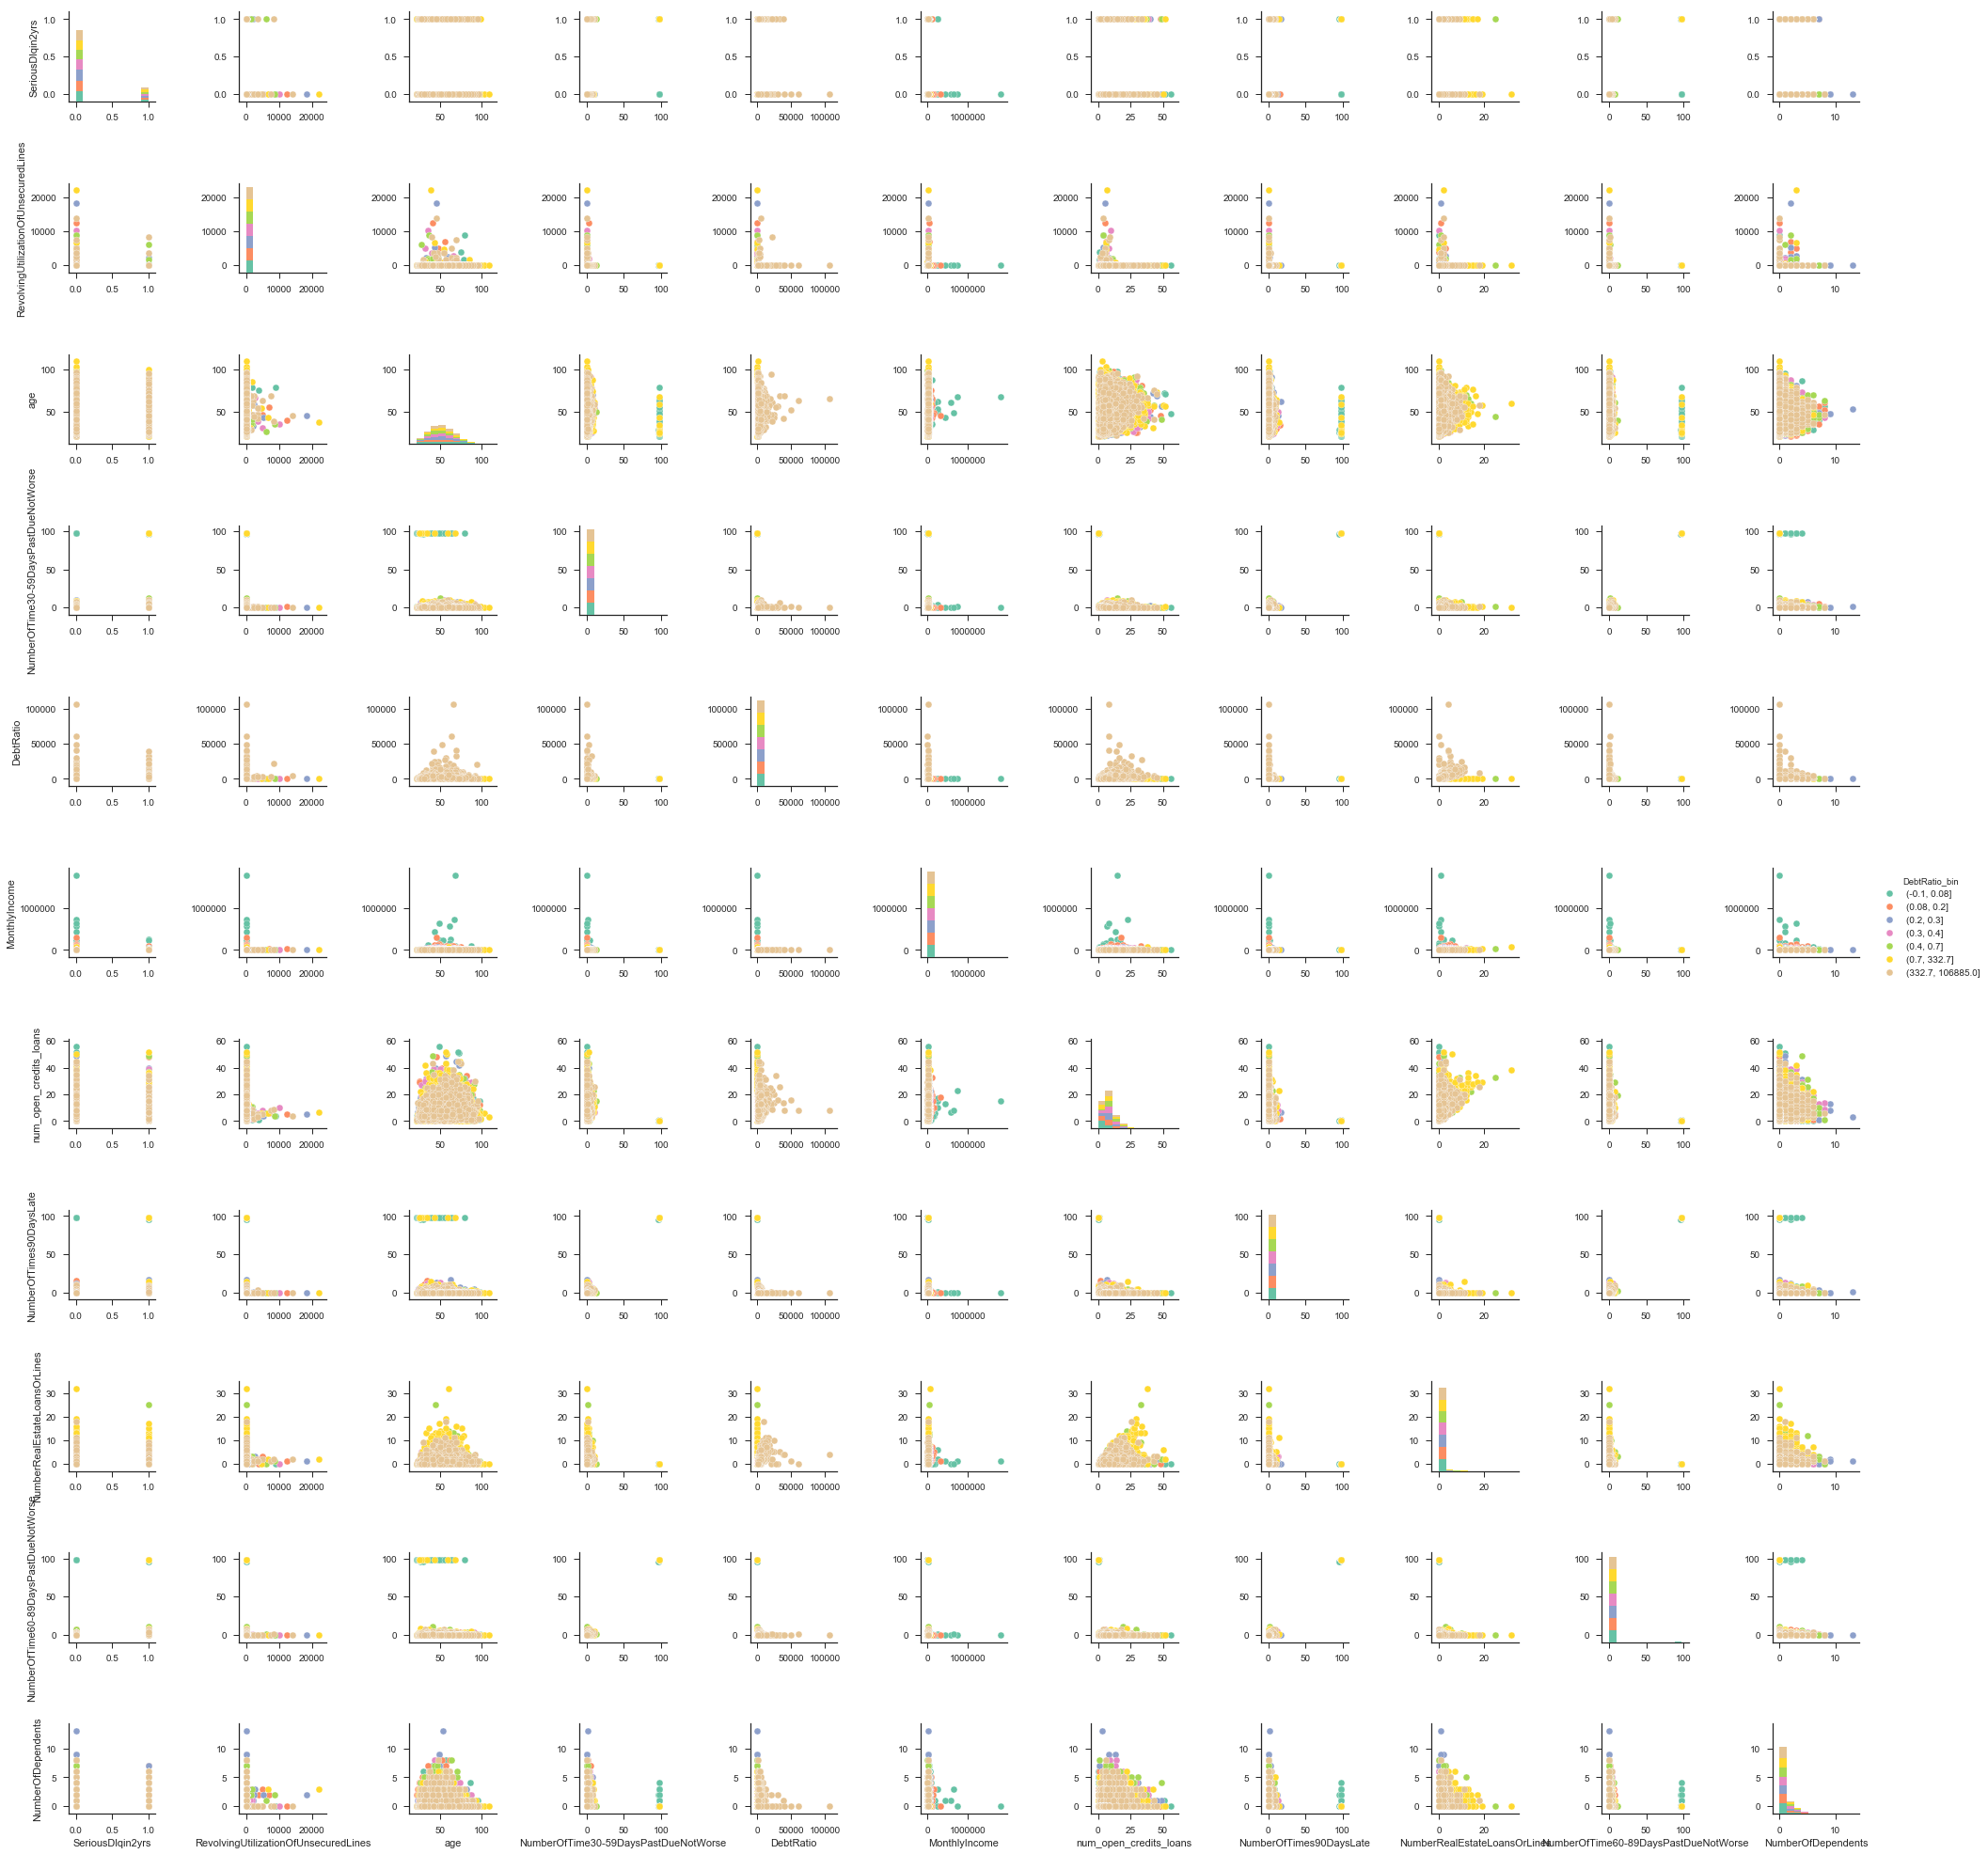

In [395]:
plot_corr(copy_df, ["zipcode"], color_category = "DebtRatio_bin")

### Open Credit Lines and Loans Breakdown by Debt Ratio, Age, and Zip Code

For the six zip codes included in sample, the median number of open credit lines majority of persons in the 31-79 age ran is 7-8, with a temporary jump in all zip codes to 9 in the 50-59 decade. only a portion of  samples in age ranges 41-69 had significantly more open lines of credit than other groups, with the vast majority in the 50-59 range.

In [389]:
def feature_by_geo(df, geo, expl_var, num_var, method = "median"):
    df_geo = df[(df[geo] != 0)]
    groupby_list = [geo] + expl_var
    if method == "median":
        geo_features = df_geo.groupby(groupby_list)[num_var].median().unstack(level = 1)
    if method == "count":
        geo_features = df_geo.groupby(groupby_list)[num_var].count().unstack(level = 1)
    geo_features.fillna(value = "", inplace = True)
    return geo_features

In [390]:
geo_req_data = feature_by_geo(copy_df, 'zipcode', ["age_bin", "DebtRatio_bin"], "num_open_credits_loans")
geo_req_data

age_bin                     [21.0, 31.0)  [31.0, 41.0)  [41.0, 50.0)  \
zipcode DebtRatio_bin                                                  
60601   (-0.1, 0.03]                 1.0           2.0           3.0   
        (0.03, 0.1]                  4.0           5.5           5.0   
        (0.1, 0.2]                   5.0           6.0           7.0   
        (0.2, 0.3]                   4.0           7.0           8.0   
        (0.3, 0.4]                   5.0           7.0           8.0   
        (0.4, 0.5]                   7.0           9.0           9.0   
        (0.5, 0.7]                   7.0           8.0           9.0   
        (0.7, 2.4]                   6.5           9.0          11.0   
        (2.4, 1160.0]                2.0           5.0           4.0   
        (1160.0, 106885.0]           7.0           7.0           8.0   
60618   (-0.1, 0.03]                 1.0           2.0           3.0   
        (0.03, 0.1]                  4.0           4.0           6.0   
        (0.1, 0.2]                   5.0           6.0           7.0   
        (0.2, 0.3]                   5.0           7.0           7.0   
        (0.3, 0.4]                   6.0           7.5           8.0   
        (0.4, 0.5]                   7.0           8.0           9.0   
        (0.5, 0.7]                   6.0           9.0          10.0   
        (0.7, 2.4]                   7.0           9.0          10.0   
        (2.4, 1160.0]                3.0           5.0           4.0   
        (1160.0, 106885.0]           7.5           8.0           7.0   
60625   (-0.1, 0.03]                 1.0           2.0           3.0   
        (0.03, 0.1]                  3.0           4.0           5.0   
        (0.1, 0.2]                   5.0           6.0           7.0   
        (0.2, 0.3]                   6.0           7.0           8.0   
        (0.3, 0.4]                   7.0           8.0           8.0   
        (0.4, 0.5]                   7.0           9.0           9.0   
        (0.5, 0.7]                   7.0           9.0          10.0   
        (0.7, 2.4]                   6.5           9.0          10.0   
        (2.4, 1160.0]                3.0           4.0           5.0   
        (1160.0, 106885.0]           8.0           7.0           8.0   
60629   (-0.1, 0.03]                 1.0           2.0           3.0   
        (0.03, 0.1]                  4.0           4.0           5.0   
        (0.1, 0.2]                   4.0           6.0           6.0   
        (0.2, 0.3]                   5.0           7.0           8.0   
        (0.3, 0.4]                   6.0           8.0           9.0   
        (0.4, 0.5]                   6.0           8.0          10.0   
        (0.5, 0.7]                   7.0           9.0          10.0   
        (0.7, 2.4]                   6.0           8.0          11.0   
        (2.4, 1160.0]                3.0           5.0           4.0   
        (1160.0, 106885.0]           5.0           7.0           9.0   
60637   (-0.1, 0.03]                 1.0           1.0           2.0   
        (0.03, 0.1]                  3.0           4.0           5.0   
        (0.1, 0.2]                   5.0           6.0           7.0   
        (0.2, 0.3]                   5.0           7.0           8.0   
        (0.3, 0.4]                   6.0           7.0           8.0   
        (0.4, 0.5]                   6.0           8.0           9.0   
        (0.5, 0.7]                   7.0           9.0          10.0   
        (0.7, 2.4]                   5.0           9.0          10.0   
        (2.4, 1160.0]                3.0           4.0           4.0   
        (1160.0, 106885.0]           8.0           8.0           9.0   
60644   (-0.1, 0.03]                 1.5           3.0           4.0   
        (0.03, 0.1]                  4.0           5.0           5.0   
        (0.1, 0.2]                   5.0           6.0           7.0   
        (0.2, 0.3]                   5.5

In [310]:
geo_req_data = feature_by_geo(copy_df, 'zipcode', ["age_bin", "DebtRatio_bin"], "num_open_credits_loans", method = "count")
geo_req_data

age_bin                     [21.0, 31.0) [31.0, 41.0) [41.0, 50.0)  \
zipcode DebtRatio_bin                                                
60601   [0.0, 11876.0)               506         1058         1562   
        [11876.0, 23752.0)                                       1   
        [47504.0, 59381.0)                                           
60618   [0.0, 11876.0)               491         1074         1479   
        [11876.0, 23752.0)                                       2   
        [23752.0, 35628.0)                                       2   
        [95009.0, 106992.0)                                          
60625   [0.0, 11876.0)               956         2215         3087   
        [11876.0, 23752.0)                          3            3   
        [23752.0, 35628.0)                                           
60629   [0.0, 11876.0)               528         1137         1489   
        [11876.0, 23752.0)                                       3   
        [23752.0, 35628.0)                                           
60637   [0.0, 11876.0)               514         1055         1546   
        [11876.0, 23752.0)                          1            1   
        [35628.0, 47504.0)                                       1   
        [59381.0, 71257.0)                                           
60644   [0.0, 11876.0)               168          414          580   
        [11876.0, 23752.0)                                       1   
        [35628.0, 47504.0)                                           

age_bin                     [50.0, 60.0) [60.0, 70.0) [70.0, 80.0)  \
zipcode DebtRatio_bin                                                
60601   [0.0, 11876.0)              1466         1078          527   
        [11876.0, 23752.0)                                           
        [47504.0, 59381.0)             1                             
60618   [0.0, 11876.0)              1498         1040          523   
        [11876.0, 23752.0)             1            1                
        [23752.0, 35628.0)             1                             
        [95009.0, 106992.0)                         1                
60625   [0.0, 11876.0)              2950         2099         1123   
        [11876.0, 23752.0)             2            3                
        [23752.0, 35628.0)                          1                
60629   [0.0, 11876.0)              1456         1085          531   
        [11876.0, 23752.0)             1                             
        [23752.0, 35628.0)             1                             
60637   [0.0, 11876.0)              1476          995          526   
        [11876.0, 23752.0)                          2                
        [35628.0, 47504.0)                                           
        [59381.0, 71257.0)                          1                
60644   [0.0, 11876.0)               568          443          259   
        [11876.0, 23752.0)                                           
        [35628.0, 47504.0)                          1                

age_bin                     [80.0, 89.0) [89.0, 99.0) [99.0, 109.0)  
zipcode DebtRatio_bin                                                
60601   [0.0, 11876.0)               195           32             1  
        [11876.0, 23752.0)                                           
        [47504.0, 59381.0)                                           
60618   [0.0, 11876.0)               194           25                
        [11876.0, 23752.0)                                           
        [23752.0, 35628.0)                                           
        [95009.0, 106992.0)                                          
60625   [0.0, 11876.0)               406           55                
        [11876.0, 23752.0)                          1                
        [23752.0, 35628.0)                                           
60629   [0.0, 11876.0)               197           30             1  
        

In [391]:
def change_col_name(df, current_name, new_name):
    df.columns = [new_name if col == current_name else col for col in df.columns]

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'zipcode', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'num_open_credits_loans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'age_bin', 'SeriousDlqin2yrs_bin',
       'RevolvingUtilizationOfUnsecuredLines_bin',
       'NumberOfTime30-59DaysPastDueNotWorse_bin', 'DebtRatio_bin',
       'MonthlyIncome_bin', 'NumberOfOpenCreditLinesAndLoans_bin',
       'NumberOfTimes90DaysLate_bin', 'NumberRealEstateLoansOrLines_bin',
       'NumberOfTime60-89DaysPastDueNotWorse_bin', 'NumberOfDependents_bin',
       'num_open_credits_loans_bin'],
      dtype='object')

In [282]:
def abs_diff(x, factor, y, MAD):
    # use sys.float_info.min to avoid dividing by zero
    if MAD == 0:
        MAD = 2.2250738585072014e-308 
    return (x - y)/ MAD

In [359]:
# Attribution: modified z-score method for identifying outliers adapted from from http://colingorrie.github.io/outlier-detection.html

def outliers_modified_z_score(df, col):
    threshold = 3.5
    zscore_factor = 0.6745
    col_median = df[col].astype(float).median()
    median_absolute_deviation = abs(df[col] - col_median).mean()
    
    modified_zscore = df[col].apply(lambda x: abs_diff(x, zscore_factor, col_median, median_absolute_deviation))
    return modified_zscore[modified_zscore > threshold]

In [362]:

x = outliers_modified_z_score(copy_df, "RevolvingUtilizationOfUnsecuredLines")
copy_df["RevolvingUtilizationOfUnsecuredLines"].loc[list(x.index)]

PersonID
105054     1924.000000
111663     4591.000000
120228     2128.000000
124630     1917.000000
125719    12369.000000
127190     2242.000000
128266     1454.000000
133296      452.000000
133624     1874.000000
138636     1855.000000
144684     1761.000000
102532     1565.000000
123072    10151.000000
143755     7555.000000
149246      771.000000
100212     2019.000000
100299     4886.000000
102164     6726.000000
103257     3214.000000
107875      978.000000
118020      532.000000
118436     2619.000000
118552      361.000000
119088     2664.000000
121585     1655.000000
122080     1194.000000
123855     1713.000000
124442     1512.000000
124534    13930.000000
128669     2376.000000
              ...     
107960     1064.000000
113174      738.000000
116079      946.000000
123582     6875.000000
123677     3484.000000
128557     1675.000000
129085     1073.000000
136988     5186.000000
142583     3825.000000
144355     1571.000000
7638       1577.000000
148829       73.846154
10

In [226]:
credit_df["NumberOfDependents"].describe()

count    41016.000000
mean         0.753681
std          1.113639
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         13.000000
Name: NumberOfDependents, dtype: float64

In [261]:
math.ceil((copy_df["age"].max() - copy_df["age"].min()) / 10)

9

In [288]:
copy_df.loc[123714, "NumberOfDependents"]

2.0

In [465]:
def isolate_noncategoricals(df):
    non_categorical = [col for col in df.columns if not re.search("_bin", col)]
    return non_categorical

In [466]:
list_noncat = isolate_noncategoricals(copy_df)

In [467]:
list_noncat


['SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'zipcode',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'num_open_credits_loans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [ ]:
def isolate_categoricals(df):
    categories_list = list(df.columns)
    return categories - 

In [365]:
def qqut_instead(df, num_bins, col):
    pd.qcut(df[col], num_bins, precision = 0)
    print(col, num_bins)

In [366]:
qqut_instead(df = copy_df, num_bins = 4, col = "DebtRatio")

DebtRatio 4


In [364]:
pd.qcut(copy_df["RevolvingUtilizationOfUnsecuredLines"], 4, precision = 0)

PersonID
98976     (0.7, 22000.0]
98991         (0.2, 0.7]
99012        (0.03, 0.2]
99023     (0.7, 22000.0]
99027       (-0.1, 0.03]
99033        (0.03, 0.2]
99044        (0.03, 0.2]
99048       (-0.1, 0.03]
99056         (0.2, 0.7]
99058        (0.03, 0.2]
99062       (-0.1, 0.03]
99104       (-0.1, 0.03]
99105       (-0.1, 0.03]
99145         (0.2, 0.7]
99147        (0.03, 0.2]
99176       (-0.1, 0.03]
99193     (0.7, 22000.0]
99200        (0.03, 0.2]
99206     (0.7, 22000.0]
99217       (-0.1, 0.03]
99218         (0.2, 0.7]
99224        (0.03, 0.2]
99233       (-0.1, 0.03]
99238       (-0.1, 0.03]
99246         (0.2, 0.7]
99249         (0.2, 0.7]
99262     (0.7, 22000.0]
99267       (-0.1, 0.03]
99271        (0.03, 0.2]
99284       (-0.1, 0.03]
               ...      
123505       (0.03, 0.2]
123523        (0.2, 0.7]
123529        (0.2, 0.7]
123532    (0.7, 22000.0]
123538      (-0.1, 0.03]
123540       (0.03, 0.2]
123541        (0.2, 0.7]
123561       (0.03, 0.2]
123597       (0.

PersonID
98976     1.000000
98991     0.547745
99012     0.044280
99023     0.914249
99027     0.026599
99033     0.142231
99044     0.047601
99048     0.022141
99056     0.241805
99058     0.036181
99062     0.000000
99104     0.000000
99105     0.007721
99145     0.549207
99147     0.183321
99176     0.000000
99193     1.000000
99200     0.056329
99206     0.828018
99217     0.029997
99218     0.607679
99224     0.099190
99233     0.019669
99238     0.001097
99246     0.365354
99249     0.325003
99262     1.000000
99267     0.018174
99271     0.125351
99284     0.000000
            ...   
123505    0.129791
123523    0.633829
123529    0.470070
123532    1.000000
123538    0.010451
123540    0.048568
123541    0.285436
123561    0.063277
123597    0.082361
123615    0.004838
123628    0.097561
123641    0.020700
123647    0.116850
123650    0.103721
123654    0.014896
123657    0.545411
123658    0.199712
123660    0.725367
123661    0.016898
123664    0.010978
123667    0.146501
123

In [396]:
credit_df.shape

(41016, 24)

In [397]:
credit_df.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'zipcode', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'num_open_credits_loans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'age_bin', 'SeriousDlqin2yrs_bin',
       'RevolvingUtilizationOfUnsecuredLines_bin',
       'NumberOfTime30-59DaysPastDueNotWorse_bin', 'DebtRatio_bin',
       'MonthlyIncome_bin', 'NumberOfOpenCreditLinesAndLoans_bin',
       'NumberOfTimes90DaysLate_bin', 'NumberRealEstateLoansOrLines_bin',
       'NumberOfTime60-89DaysPastDueNotWorse_bin', 'NumberOfDependents_bin',
       'num_open_credits_loans_bin'],
      dtype='object')